In [1]:
%cd ..

/Users/pstock/Documents/privacy_lint


In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from privacy_lint.attack_results import AttackResults
from privacy_lint.attacks.loss import LossAttack, compute_loss_cross_entropy

import matplotlib.pyplot as plt
%matplotlib inline 

## Creating linear classifier on a Gaussian mixture

In [3]:
n_class = 10

n_train = 20 * n_class
n_test = 20 * n_class
sigma = 10

d = 1000

model = nn.Linear(d, n_class)

In [4]:
train_class = torch.arange(0, n_train / n_class)

train_y = torch.arange(0, n_class).repeat_interleave(n_train // n_class)
class_centers = torch.randn(n_class, d)
train_x = class_centers[train_y] + sigma * torch.randn(n_train, d)

test_y = torch.arange(0, n_class).repeat_interleave(n_test // n_class)
test_x = class_centers[test_y] + sigma * torch.randn(n_train, d)

trainset = TensorDataset(train_x, train_y)
testset = TensorDataset(test_x, test_y)

In [5]:
train_loader = DataLoader(trainset, batch_size=64)
test_loader = DataLoader(testset, batch_size=n_test)

## Training

In [6]:
criterion = nn.CrossEntropyLoss()

losses = []
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
for epoch in range(2):
    for inp, out in train_loader:
        loss = criterion(model(inp), out)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

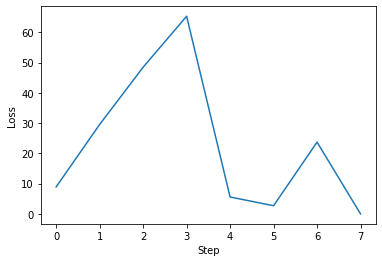

In [7]:
plt.plot(losses)
plt.xlabel("Step")
_ = plt.ylabel("Loss")

## Privacy attack of the model

In [8]:
attack = LossAttack(compute_loss=compute_loss_cross_entropy)
loss_results = attack.launch(model, train_loader, test_loader)

100%|██████████| 1/1 [00:00<00:00, 426.81it/s]


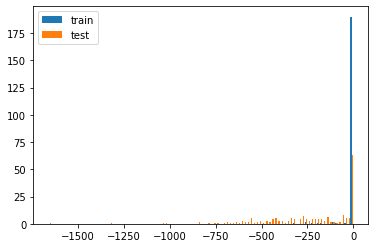

In [9]:
_ = plt.hist([loss_results.scores_train.numpy(), loss_results.scores_test.numpy()], label=['train', 'test'], bins=100)
plt.legend()

We can see that it is possible to separate training and test points

In [10]:
loss_results.get_max_accuracy_threshold()

(0.0, 0.9350000023841858)

In [11]:
precision, recall = loss_results.get_precision_recall()

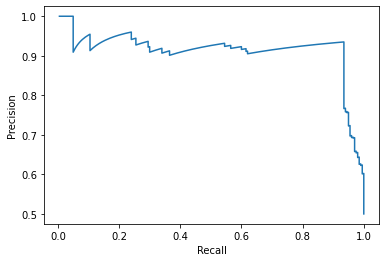

In [12]:
plt.plot(recall, precision)
plt.xlabel('Recall')
_ = plt.ylabel('Precision')